# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации

Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)

Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.

In [1]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM

C:\Users\mdime\AppData\Roaming\Python\Python38\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

In [4]:
books = pd.read_csv("./data/BX-Books.csv", low_memory=False)

interactions = pd.read_csv("./data/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

interactions = interactions[interactions["Book-Rating"] != 0]

interactions

User-ID         ISBN  Book-Rating
1         276726   0155061224            5
3         276729   052165615X            3
4         276729   0521795028            6
6         276736   3257224281            8
7         276737   0600570967            6
...          ...          ...          ...
1149773   276704   0806917695            5
1149775   276704   1563526298            9
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[433671 rows x 3 columns]

In [38]:
books

ISBN                                         Book-Title  \
0       0195153448                                Classical Mythology   
1       0002005018                                       Clara Callan   
2       0060973129                               Decision in Normandy   
3       0374157065  Flu: The Story of the Great Influenza Pandemic...   
4       0393045218                             The Mummies of Urumchi   
...            ...                                                ...   
271355  0440400988                         There's a Bat in Bunk Five   
271356  0525447644                            From One to One Hundred   
271357  006008667X  Lily Dale : The True Story of the Town that Ta...   
271358  0192126040                        Republic (World's Classics)   
271359  0767409752  A Guided Tour of Rene Descartes' Meditations o...   

                 Book-Author Year-Of-Publication  \
0         Mark P. O. Morford                2002   
1       Richard Bruce Wright                2001   
2               Carlo D'Este                1991   
3           Gina Bari Kolata                1999   
4            E. J. W. Barber                1999   
...                      ...                 ...   
271355        Paula Danziger                1988   
271356            Teri Sloat                1991   
271357      Christine Wicker                2004   
271358                 Plato                1996   
271359   Christopher  Biffle                2000   

                                               Publisher  \
0                                Oxford University Press   
1                                  HarperFlamingo Canada   
2                                        HarperPerennial   
3                                   Farrar Straus Giroux   
4                             W. W. Norton &amp; Company   
...                                                  ...   
271355                   Random House Childrens Pub (Mm)   
271356                                      Dutton Books   
271357                                HarperSanFrancisco   
271358                           Oxford University Press   
271359  McGraw-Hill Humanities/Social Sciences/Languages   

                                              Image-URL-S  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271355  http://images.amazon.com/images/P/0440400988.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-M  \
0       http://images.amazon.com/images/P/0195153448.0...   
1       http://images.amazon.com/images/P/0002005018.0...   
2       http://images.amazon.com/images/P/0060973129.0...   
3       http://images.amazon.com/images/P/0374157065.0...   
4       http://images.amazon.com/images/P/0393045218.0...   
...                                                   ...   
271355  http://images.amazon.com/images/P/0440400988.0...   
271356  http://images.amazon.com/images/P/0525447644.0...   
271357  http://images.amazon.com/images/P/006008667X.0...   
271358  http://images.amazon.com/images/P/0192126040.0...   
271359  http://images.amazon.com/images/P/0767409752.0...   

                                              Image-URL-L  
0       http://images.amazon.com/images/P/0195153448.0...  
1       http://images.amazon.com/images/P/0002005018.0...  
2       http://images.amazon.com/images/P/0060973129.0...  
3       http://images.amazon.com/images/P/0374157065.0...  
4       http://images.ama

In [45]:
books[books['Book-Author'] == 'J. K. Rowling']

ISBN                                         Book-Title  \
2143    059035342X  Harry Potter and the Sorcerer's Stone (Harry P...   
2809    0590353403     Harry Potter and the Sorcerer's Stone (Book 1)   
3459    0439064872   Harry Potter and the Chamber of Secrets (Book 2)   
3839    0439136350  Harry Potter and the Prisoner of Azkaban (Book 3)   
3914    0613329740                         Quidditch Through the Ages   
...            ...                                                ...   
213701  0439567629  Harry Potter and the Order of the Phoenix (Boo...   
234605  1594130000              Harry Potter and the Sorcerer's Stone   
234611  0439294827  Harry Potter and the Sorcerer's Stone: A Delux...   
251233  847888663X                   Harry Potter y El Caliz de Fuego   
257263  043955490X  Harry Potter and the Goblet of Fire (Harry Pot...   

          Book-Author Year-Of-Publication                      Publisher  \
2143    J. K. Rowling                1999         Arthur A. Levine Books   
2809    J. K. Rowling                1998                     Scholastic   
3459    J. K. Rowling                2000                     Scholastic   
3839    J. K. Rowling                1999                     Scholastic   
3914    J. K. Rowling                2001  Sagebrush Education Resources   
...               ...                 ...                            ...   
213701  J. K. Rowling                2003                     Scholastic   
234605  J. K. Rowling                2003              Large Print Press   
234611  J. K. Rowling                2001                     Scholastic   
251233  J. K. Rowling                2001                         Lidiun   
257263  J. K. Rowling                2003         Arthur A. Levine Books   

                                              Image-URL-S  \
2143    http://images.amazon.com/images/P/059035342X.0...   
2809    http://images.amazon.com/images/P/0590353403.0...   
3459    http://images.amazon.com/images/P/0439064872.0...   
3839    http://images.amazon.com/images/P/0439136350.0...   
3914    http://images.amazon.com/images/P/0613329740.0...   
...                                                   ...   
213701  http://images.amazon.com/images/P/0439567629.0...   
234605  http://images.amazon.com/images/P/1594130000.0...   
234611  http://images.amazon.com/images/P/0439294827.0...   
251233  http://images.amazon.com/images/P/847888663X.0...   
257263  http://images.amazon.com/images/P/043955490X.0...   

                                              Image-URL-M  \
2143    http://images.amazon.com/images/P/059035342X.0...   
2809    http://images.amazon.com/images/P/0590353403.0...   
3459    http://images.amazon.com/images/P/0439064872.0...   
3839    http://images.amazon.com/images/P/0439136350.0...   
3914    http://images.amazon.com/images/P/0613329740.0...   
...                                                   ...   
213701  http://images.amazon.com/images/P/0439567629.0...   
234605  http://images.amazon.com/images/P/1594130000.0...   
234611  http://images.amazon.com/images/P/0439294827.0...   
251233  http://images.amazon.com/images/P/847888663X.0...   
257263  http://images.amazon.com/images/P/043955490X.0...   

                                              Image-URL-L  
2143    http://images.amazon.com/images/P/059035342X.0...  
2809    http://images.amazon.com/images/P/0590353403.0...  
3459    http://images.amazon.com/images/P/0439064872.0...  
3839    http://images.amazon.com/images/P/0439136350.0...  
3914    http://images.amazon.com/images/P/0613329740.0...  
...                                                   ...  
213701  http://images.amazon.com/images/P/0439567629.0...  
234605  http://images.amazon.com/images/P/1594130000.0...  
234611  http://images.amazon.com/images/P/0439294827.0...  
251233  http://images.amazon.com/images/P/847888663X.0...  
257263  http://images.amazon.com/images/P/043955490X.0...  

[78 rows x 8 columns]

In [6]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [7]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [11]:
users = pd.read_csv('./data/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

In [12]:
users

User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]

In [13]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [14]:
interactions = interactions.merge(users[["Location", "User-ID", "Age"]], on=["User-ID"])

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [16]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [17]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [18]:
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1    86583  3453061187            8        13         18   
2    86583  3426609061            7         8         18   
3   132500  3404139178           10         8         43   
4   132500  3499232871            8        11         43   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3453061187.0...   
2  http://images.amazon.com/images/P/3426609061.0...   
3  http://images.amazon.com/images/P/3404139178.0...   
4  http://images.amazon.com/images/P/3499232871.0...   

                                    Book-Title              Location   Age  \
0  Das Lacheln der Fortuna: Historischer Roman  stuttgart, , germany  31.0   
1                             Die Jury. Roman.  stuttgart, , germany  31.0   
2                                House Of God.  stuttgart, , germany  31.0   
3  Das Lacheln der Fortuna: Historischer Roman              fürth, ,  29.0   
4                                   Herzsprung              fürth, ,  29.0   

   product_id   vid  
0       10397  3445  
1       10495  3445  
2       10428  3445  
3       10397  5248  
4       10552  5248

In [19]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 1074 	Book Title: David Copperfield (Penguin Classics)
idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)


In [20]:
interactions[interactions["ISBN"] == "0505524473"]

User-ID        ISBN  Book-Rating  user_num  books_num  \
42213    102702  0505524473           10         9        199   
65762    244685  0505524473            9         9        109   
105236   229334  0505524473           10         9         38   

                                              picture_url Book-Title  \
42213   http://images.amazon.com/images/P/0505524473.0...  Dark Fire   
65762   http://images.amazon.com/images/P/0505524473.0...  Dark Fire   
105236  http://images.amazon.com/images/P/0505524473.0...  Dark Fire   

                          Location   Age  product_id   vid  
42213        honolulu, hawaii, usa  34.0        5948  4083  
65762         rockvale, tennessee,   NaN        5948  9646  
105236  fort carson, colorado, usa  30.0        5948  8991

## 1) Топ в зависимости от страны и возраста

In [21]:
def determine_country(x):
    return x.split()[-1]

Из лекции:

In [27]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [28]:
class Top():
    def __init__(self, Int, country, age):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.delta = 15
        self.age = age
        self.country = country
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
#         df_with_correct_users = df_with_correct_users[df_with_correct_users["Age"] <= age + delta]]
    def top_items(self):
        # Хотим получить в отсортированном порядке датафрейм - product_id, user_number
        items = self.interactions[self.interactions["Age"] >= self.age - self.delta]
        items = items[items["Age"] <= self.age + self.delta]
        items = items[items["Location"].apply(determine_country) == self.country]\
                                                .groupby("product_id")["vid"].count() \
                                                .reset_index() \
                                                .sort_values("vid", ascending=False)[:10]
        
        rec_imaging(items["product_id"].values, self.product_id_to_url, items["vid"].values)

In [29]:
T = Top(interactions, "usa", 30)

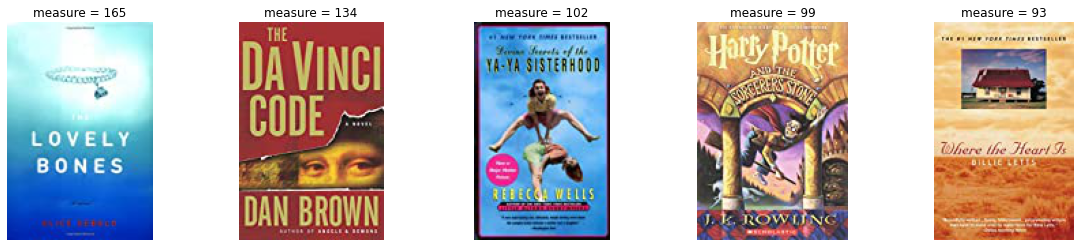

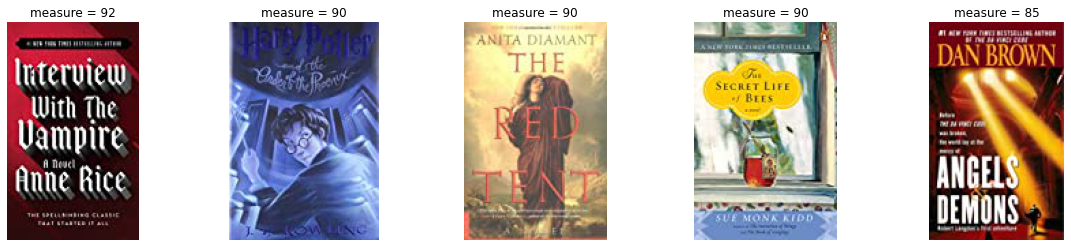

In [30]:
T.top_items()

Собственная реализация (это потому что я не учитываю средние оценки :

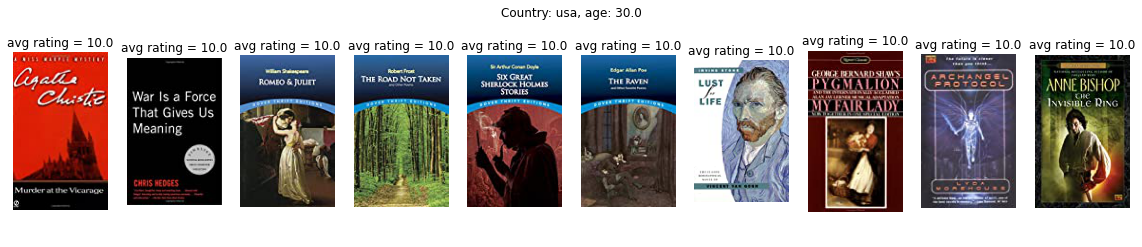

In [25]:
def personal_top(country, age):
    delta = 15
    df_with_correct_users = interactions[interactions["Age"] >= age - delta]
    df_with_correct_users = df_with_correct_users[df_with_correct_users["Age"] <= age + delta]
    df_with_correct_users = df_with_correct_users[df_with_correct_users["Location"].apply(determine_country) == country]
    return df_with_correct_users

Country = "usa"
Age = 30
t = personal_top(Country, Age).groupby("ISBN")["Book-Rating"].mean()
t = t.sort_values()[::-1][1:11]
t = np.vstack((t.index, t))
fig = plt.figure(figsize=(20, 4))
plt.title("Country: %s, age: %.1f" % (Country, Age))
plt.axis('off')
cnt = 0
for i in np.arange(t.shape[1]):
    r = requests.get(books[books["ISBN"] == t[0,i]]["Image-URL-M"].values[0])
    im = Image.open(BytesIO(r.content))
    a = fig.add_subplot(1, 10, i + 1)
    a.title.set_text("avg rating = {}".format(np.round(t[1,i], 4)))
    cnt += 1
    plt.imshow(im)
    plt.axis('off')

In [26]:
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1    86583  3453061187            8        13         18   
2    86583  3426609061            7         8         18   
3   132500  3404139178           10         8         43   
4   132500  3499232871            8        11         43   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3453061187.0...   
2  http://images.amazon.com/images/P/3426609061.0...   
3  http://images.amazon.com/images/P/3404139178.0...   
4  http://images.amazon.com/images/P/3499232871.0...   

                                    Book-Title              Location   Age  \
0  Das Lacheln der Fortuna: Historischer Roman  stuttgart, , germany  31.0   
1                             Die Jury. Roman.  stuttgart, , germany  31.0   
2                                House Of God.  stuttgart, , germany  31.0   
3  Das Lacheln der Fortuna: Historischer Roman              fürth, ,  29.0   
4                                   Herzsprung              fürth, ,  29.0   

   product_id   vid  
0       10397  3445  
1       10495  3445  
2       10428  3445  
3       10397  5248  
4       10552  5248

### 3) ~~Копирование~~ Применение лекций

Совстречаемость:

In [31]:
class Recomendations():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        # Фильтруем пользователей, взаимодействовавших с одним товаром
        user_products = user_products[user_products["prod_num"] > 1]
        
        # Заводим словарь под товары
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            # Если товары встетились вместе больше одного раза, то добавляем в список
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [32]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

<ipython-input-31-bc746ecc6ff3>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(user_products.values):


  0%|          | 0/10012 [00:00<?, ?it/s]

Для товара


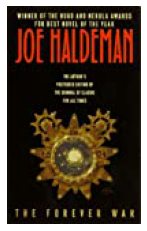

Такие рекомендации


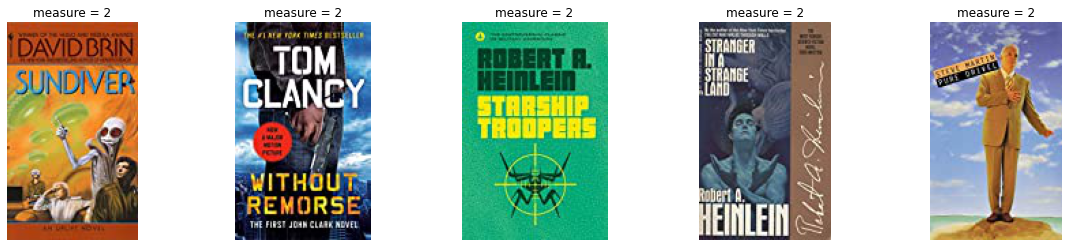

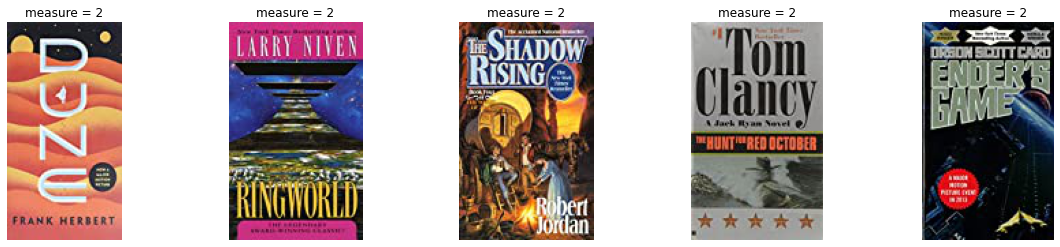

In [47]:
cooc_rec.get_rec(2809)

Для товара


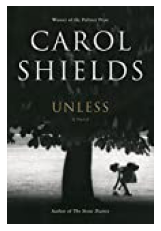

Такие рекомендации


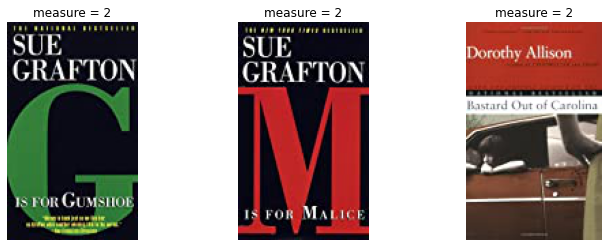

In [34]:
cooc_rec.get_rec(15)

Collaborative filtering:

In [ ]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = j
        self.csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
#         df_weights = pd.DataFrame({"page_type": ["PRODUCT", "CART", "PURCHASE"],
#                                    'weight': [1, 1, 1]})
#         weighted = interactions.merge(df_weights, on="page_type")\
#                           .groupby(["vid", "product_id", "picture_url"])["weight"]\
#                           .sum()\
#                           .reset_index()
#         weighted["weight"] = (weighted["weight"] > 0).astype(int)
#         self.csr_rates = coo_matrix((weighted["weight"], (weighted["vid"], weighted["product_id"])), 
#                             shape=(len(set(weighted["vid"])), len(set(weighted["product_id"]))))
        

    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        # считаем косинус между пользователем idx и всеми пользователями
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        # чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]
        # печатаем рекомендации
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        # считаем косинус между товаром idx и всеми пользователями
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        # печатаем рекомендации
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [ ]:
clb = Colloborative(interactions)

Для таких товаров


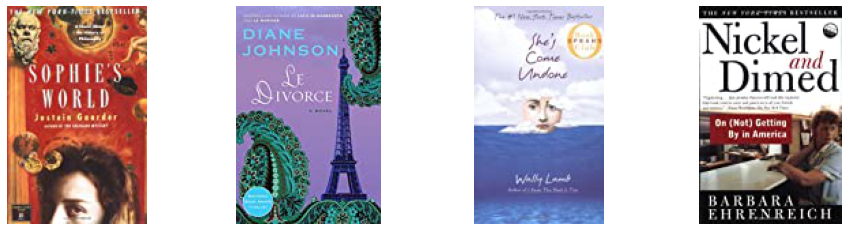

Такие рекомендации


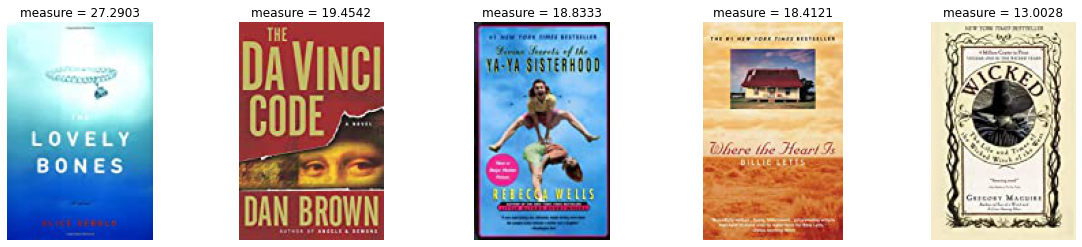

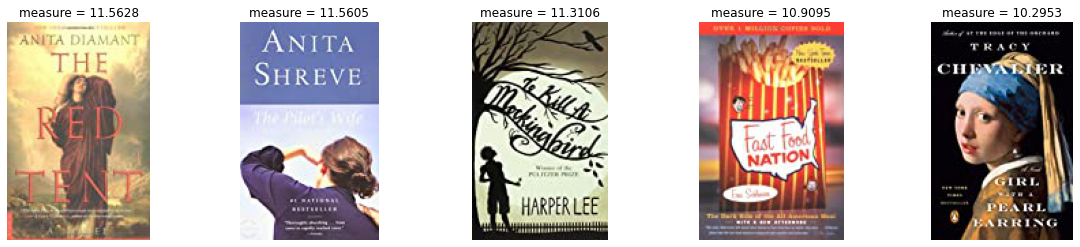

In [ ]:
clb.user_based(10)

Для таких товаров


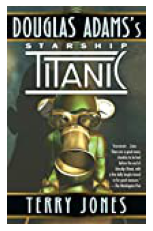

Такие рекомендации


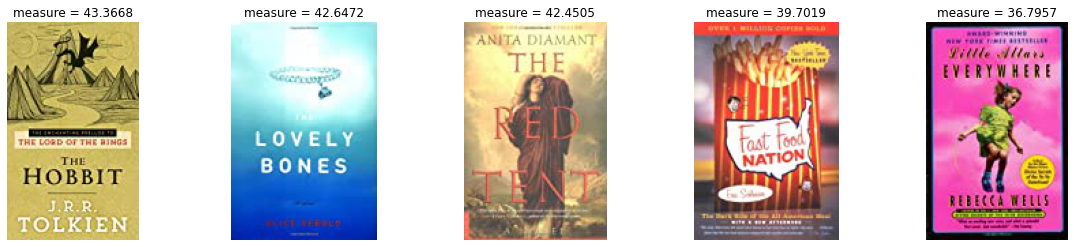

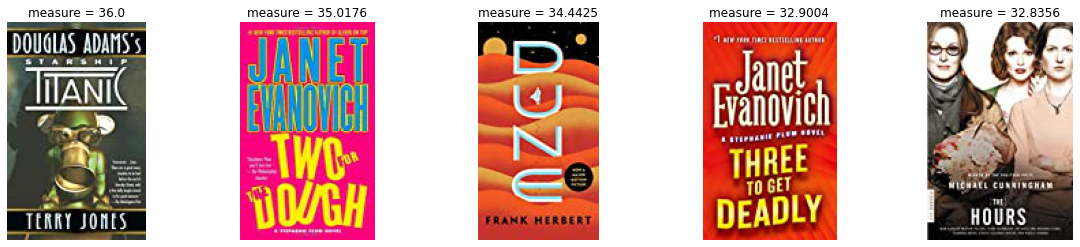

In [ ]:
clb.item_based(2000)